In [48]:
import numpy as np
from os.path import expanduser
import pyret.filtertools as ft
import pyret.visualizations as viz
import h5py
import matplotlib.pyplot as plt
%matplotlib qt

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

ERROR:tornado.application:Exception in callback <functools.partial object at 0x1198d2f18>
Traceback (most recent call last):
  File "/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/tornado/ioloop.py", line 568, in _run_callback
    ret = callback()
  File "/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/lmcintosh/Git/ipython/IPython/kernel/zmq/kernelbase.py", line 234, in enter_eventloop
    self.eventloop(self)
  File "/Users/lmcintosh/Git/ipython/IPython/kernel/zmq/eventloops.py", line 73, in loop_qt4
    _notify_stream_qt(kernel, s)
  File "/Users/lmcintosh/Git/ipython/IPython/kernel/zmq/eventloops.py", line 21, in _notify_stream_qt
    from appnope import nope_scope as context
ImportError: No module named appnope


In [4]:
weights_dir = expanduser('~/Dropbox/deep-retina/saved_models/2015-11-05 15.50.00 Convnet/conv-lstm_weights_on_epoch.hdf5')

In [5]:
weights = h5py.File(weights_dir, 'r')

## Layers 0, 4, and 6 have weights

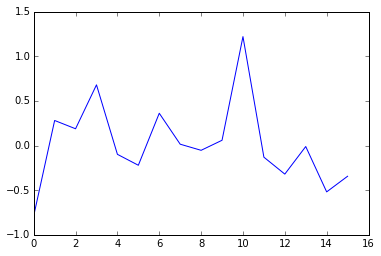

In [19]:
plt.plot(weights['layer_0']['param_1'][:])

### Choose the filter with the largest magnitude bias

In [23]:
best_filter_idx = np.argmax(abs(weights['layer_0']['param_1'][:]))

In [27]:
W0 = weights['layer_0']['param_0']
print(W0.shape)
W0_strongest = W0[best_filter_idx]

(16, 40, 9, 9)


# Averaging over all temporal slices

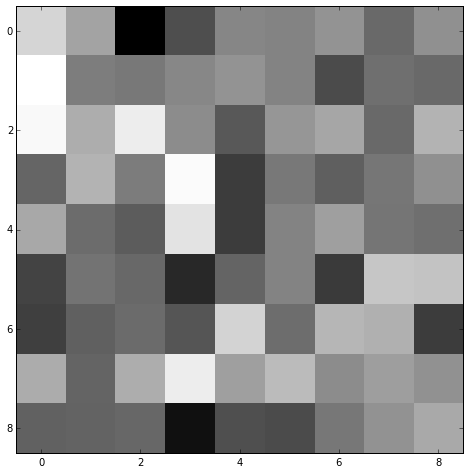

In [39]:
plt.imshow(np.sum(W0_strongest, axis=0))

In [41]:
space, time = ft.decompose(W0_strongest)

In [42]:
space.shape

(9, 9)

In [43]:
time.shape

(40,)

(<matplotlib.figure.Figure at 0x1199106d0>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x119910990>,
  <matplotlib.axes._subplots.AxesSubplot at 0x119910cd0>))

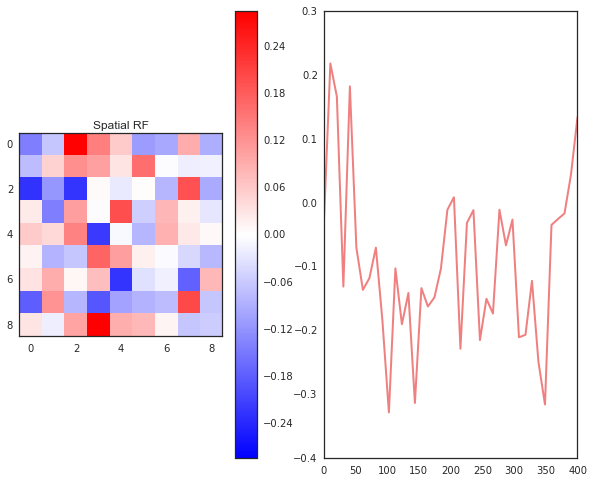

In [49]:
viz.plotsta(np.linspace(0,400,40), W0_strongest)

# What does the actual receptive field look like? (Natural Scenes)

In [50]:
data_dir = '/Users/lmcintosh/Documents/Stanford/00 Baccus Lab/Data 2015_10_07/naturalscene.h5'

In [53]:
def rolling_window(array, window):
	"""
	Make an ndarray with a rolling window of the last dimension
	Parameters
	----------
	array : array_like
		Array to add rolling window to
	window : int
		Size of rolling window
	Returns
	-------
	Array that is a view of the original array with a added dimension
	of size w.
	Examples
	--------
	>>> x=np.arange(10).reshape((2,5))
	>>> rolling_window(x, 3)
	array([[[0, 1, 2], [1, 2, 3], [2, 3, 4]],
		   [[5, 6, 7], [6, 7, 8], [7, 8, 9]]])
	Calculate rolling mean of last dimension:
	>>> np.mean(rolling_window(x, 3), -1)
	array([[ 1.,  2.,  3.],
		   [ 6.,  7.,  8.]])
	"""
	assert window >= 1, "`window` must be at least 1."
	assert window < array.shape[-1], "`window` is too long."

	# # with strides
	shape = array.shape[:-1] + (array.shape[-1] - window, window)
	strides = array.strides + (array.strides[-1],)
	return np.lib.stride_tricks.as_strided(array, shape=shape, strides=strides)

In [54]:
def loadData(data_dir):
	scenes = h5py.File(data_dir, 'r')
	stim = np.array(scenes['train/stimulus'])
	stim = stim.T
	X = rolling_window(stim, 40)
	X = np.rollaxis(X, 2)
	X = np.rollaxis(X, 3, 1)
	#Truncate rates to appropriate time frame
	y = np.array(scenes['train/response/firing_rate_10ms'])
	for i in xrange(y.shape[0]): #normalize firing rate of each cell to be between 0 and 1
		if np.max(y[i]) != 0:
			y[i] /= np.max(y[i])
	y = y.T
	y = y[40:,:]
	stim_2 = np.array(scenes['test/stimulus'])
	stim_2 = stim_2.T
	X_2 = rolling_window(stim_2, 40)
	X_2 = np.rollaxis(X_2, 2)
	X_2 = np.rollaxis(X_2, 3, 1)
	#Truncate rates to appropriate time frame
	y_2 = np.array(scenes['test/response/firing_rate_10ms'])
	for i in xrange(y_2.shape[0]): #normalize firing rate of each cell to be between 0 and 1
		if np.max(y_2[i]) != 0:
			y_2[i] /= np.max(y_2[i])
	y_2 = y_2.T
	y_2 = y_2[40:,:]
	print X.shape
	print y.shape
	print X_2.shape
	print y_2.shape
	return X, y, X_2, y_2

In [55]:
X_train, y_train, X_test, y_test = loadData(data_dir)

(359762, 40, 50, 50)
(359762, 9)
(5957, 40, 50, 50)
(5957, 9)


In [56]:
sta = np.zeros_like(X_train[0], dtype='float32')
for idx, label in enumerate(y_train[:,0]):
    sta += label * X_train[idx].astype('float32')

(<matplotlib.figure.Figure at 0x1242697d0>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x116680510>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1242a9110>))

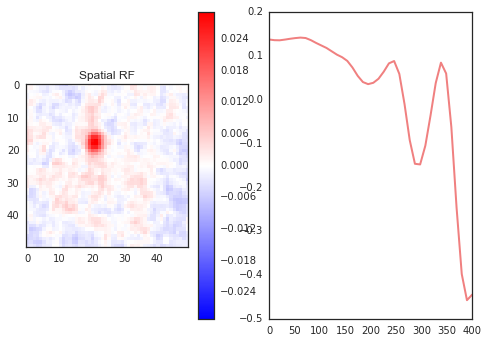

In [57]:
viz.plotsta(np.linspace(0,400,40), sta)

# Full resolution spatial STA and the true 9x9 receptive field center

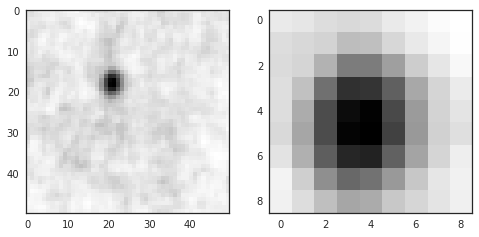

In [90]:
spatial_sta, temporal_sta = ft.decompose(sta)
plt.subplot(1,2,1)
plt.imshow(spatial_sta)
plt.subplot(1,2,2)
plt.imshow(spatial_sta[13:22,17:26])

# Plot all 16 filters in layer_0

In [76]:
(np.min(W0), np.max(W0))

(-0.25516471, 0.226861)

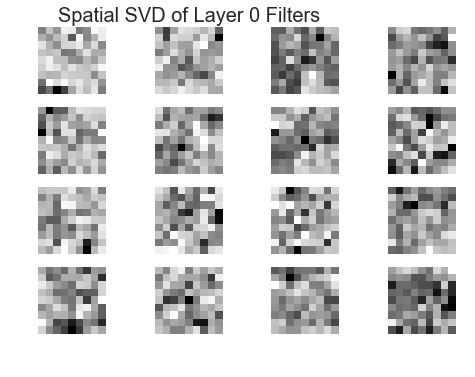

In [78]:
num_cols = 4
num_rows = 4
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        space,time = ft.decompose(W0[plt_idx-1])
        plt.subplot(num_rows, num_cols, plt_idx)
        plt.imshow(space) #, clim=[np.min(W0), np.max(W0)])
        plt.grid('off')
        plt.axis('off')
        if i == num_rows-1:
            plt.xlabel('Time (samples)', fontsize=14)
        if y == 0:
            plt.ylabel('Space (samples)', fontsize=14)
        if i == 0:
            if y == 1:
                plt.title('Spatial SVD of Layer 0 Filters', fontsize=20)

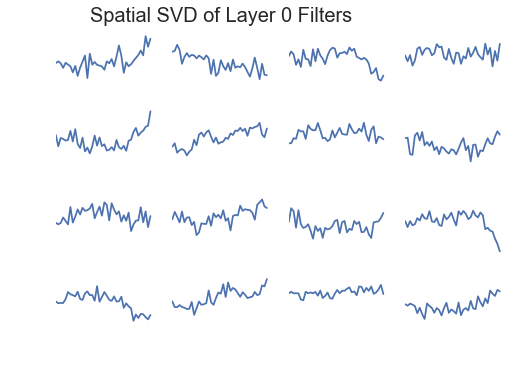

In [74]:
num_cols = 4
num_rows = 4
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        space,time = ft.decompose(W0[plt_idx-1])
        if plt_idx == 1:
            ax1 = plt.subplot(num_rows, num_cols, plt_idx)
        else:
            plt.subplot(num_rows, num_cols, plt_idx, sharey=ax1)
        plt.plot(time)
        plt.grid('off')
        plt.axis('off')
        if i == num_rows-1:
            plt.xlabel('Time (samples)', fontsize=14)
        if y == 0:
            plt.ylabel('Space (samples)', fontsize=14)
        if i == 0:
            if y == 1:
                plt.title('Spatial SVD of Layer 0 Filters', fontsize=20)

# Plot all 32 filters in layer 4

In [65]:
W4 = weights['layer_4']['param_0']
W4.shape

(13456, 32)

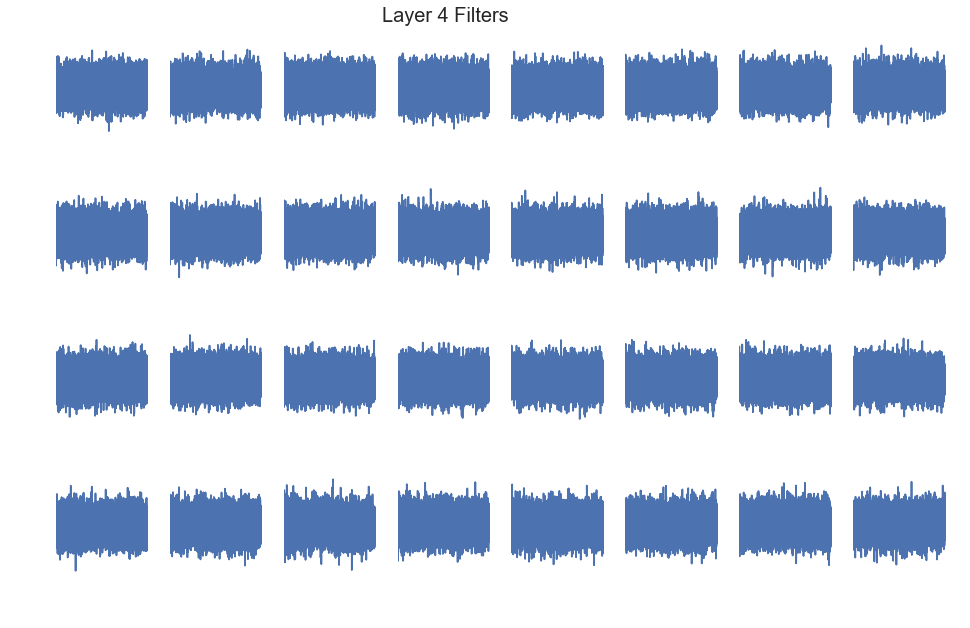

In [73]:
fig = plt.gcf()
fig.set_size_inches((16,10))
num_cols = 8
num_rows = 4
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        if plt_idx == 1:
            ax1 = plt.subplot(num_rows, num_cols, plt_idx)
        else:
            plt.subplot(num_rows, num_cols, plt_idx, sharey=ax1)
        plt.plot(W4[:,plt_idx-1])
        plt.grid('off')
        plt.axis('off')
        if i == num_rows-1:
            plt.xlabel('Time (samples)', fontsize=14)
        if y == 0:
            plt.ylabel('Space (samples)', fontsize=14)
        if i == 0:
            if y == 3:
                plt.title('Layer 4 Filters', fontsize=20)